## Figure 4
Results from a parcel simulation with Na = 100 cm-3, Forg = 0.5, and w = 5 mm/s.
Subplot a) shows the vertical profile of CDNC from cloud base to +200m. Subplot b) shows the droplet size distribution at +200m.

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install "open_atmos_jupyter_utils"
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
# import os
# os.environ["NUMBA_DISABLE_JIT"] = "0"
# os.environ["NUMBA_DEVELOPER_MODE"] = "1"

import warnings
from numba.core.errors import NumbaExperimentalFeatureWarning

import numpy as np
import matplotlib
from matplotlib import pyplot

from PySDM.initialisation.sampling import spectral_sampling as spec_sampling
from PySDM.initialisation.spectra import Sum
from PySDM.physics import si

from open_atmos_jupyter_utils import show_plot

from PySDM_examples.Singer_Ward import Settings, ParcelSimulation
from PySDM_examples.Singer_Ward.aerosol import AerosolBetaCaryophylleneDark

In [6]:
from PySDM.physics import constants_defaults
CONSTANTS = {
    "MAC":1,
    "HAC":1,
    "scipy_solver":False,
    'Mv': constants_defaults.Mv,
    'rho_w': constants_defaults.rho_w
}

output = {}

lines = {'Constant': '-', 'CompressedFilmOvadnevaite': '--', 
    'SzyszkowskiLangmuir': '-.', 'CompressedFilmRuehl': ':'}
colors = {'Constant': 'k', 'CompressedFilmOvadnevaite': 'C0', 
    'SzyszkowskiLangmuir': 'C2', 'CompressedFilmRuehl': 'C1'}
names = {'Constant': 'CONST', 'CompressedFilmOvadnevaite': 'OV', 
    'SzyszkowskiLangmuir': 'SL', 'CompressedFilmRuehl': 'RU'}


WATER_MOLAR_VOLUME = CONSTANTS['Mv'] / CONSTANTS['rho_w']
aerosol = AerosolBetaCaryophylleneDark(water_molar_volume=WATER_MOLAR_VOLUME, Forg=0.5, N=200)
for model in ('Constant', 'CompressedFilmOvadnevaite', 'SzyszkowskiLangmuir', 'CompressedFilmRuehl'):
    print(model)
    key = f"{aerosol.__class__.__name__}-{model}"
    settings = Settings(
        dz=1*si.m,
        n_sd_per_mode=100, 
        model=model,
        aerosol=aerosol,
        spectral_sampling=spec_sampling.ConstantMultiplicity,
        **CONSTANTS
    )
    # TODO move catch warnings to Settings and Simulation to avoid cluttering the notebook
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=NumbaExperimentalFeatureWarning)
        simulation = ParcelSimulation(settings)
        output[key] = simulation.run()
    output[key]['color'] = colors[model]
    output[key]['linestyle'] = lines[model]
    output[key]['Na_tot'] = Sum(
        tuple(settings.aerosol.modes[i]['spectrum']
                for i in range(len(settings.aerosol.modes)))).norm_factor

Constant
CompressedFilmOvadnevaite
SzyszkowskiLangmuir
CompressedFilmRuehl


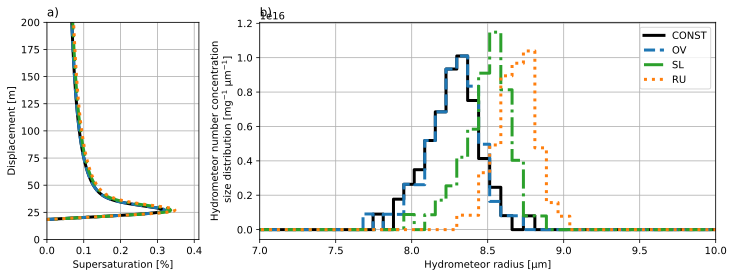

HTML(value="<a href='./fig2.pdf' target='_blank'>./fig2.pdf</a><br>")

In [7]:
fig, axes = pyplot.subplots(1, 2, figsize=(12,4), gridspec_kw={"width_ratios":[1,3]})

var = "S_max"
ax = axes[0]
for key, output_k in output.items():
    model = key.split("-")[-1]
    Y = np.asarray(output_k['z'])
    ax.plot(output_k[var], Y, 
            label=names[model], 
            color=output_k['color'],
            linestyle=output_k['linestyle'],
            lw=3,
            )
ax.set_ylim(0, 200)
ax.set_ylabel('Displacement [m]')
ax.set_xlim(0)
ax.set_xlabel('Supersaturation [%]')
ax.grid()
ax.set_title("a)", loc="left")

#######################

ax = axes[1]
record_number = -1
for key, output_k in output.items():
    model = key.split("-")[-1]
    ax.step(
        settings.wet_radius_bins_edges[:-1] / si.um,
        output_k['spectrum'],
        label=names[model],
        color=output_k['color'],
        linestyle=output_k['linestyle'],
        lw=3,
        where='pre'
    )
ax.grid()
ax.legend()
ax.set_xlabel("Hydrometeor radius [μm]")
ax.set_ylabel("Hydrometeor number concentration\n size distribution [mg$^{-1}$ μm$^{-1}$]")
ax.set_xlim(7,10)
ax.set_title("b)", loc="left")

show_plot("fig2.pdf")